# Day 37

# 단순 Seasonal ARIMA 모형

## 확률 과정을 이루는 계절 추세

대기중 이산화탄소 농도에 대한 시계열 자료를 보자.

In [14]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = sm.datasets.get_rdataset("co2")
df = data.data

def yearfraction2datetime(yearfraction, startyear=0):
    import datetime, dateutil
    year = int(yearfraction) + startyear
    month = int(round(12 * (yearfraction - year)))
    delta = dateutil.relativedelta.relativedelta(months=month)
    date = datetime.datetime(year, 1, 1) + delta
    return date

df["datetime"] = df.time.map(yearfraction2datetime)
df.tail()

,time,co2,datetime
463,1997.583333,362.57,1997-08-01
464,1997.666667,360.24,1997-09-01
465,1997.750000,360.83,1997-10-01
466,1997.833333,362.49,1997-11-01
467,1997.916667,364.34,1997-12-01


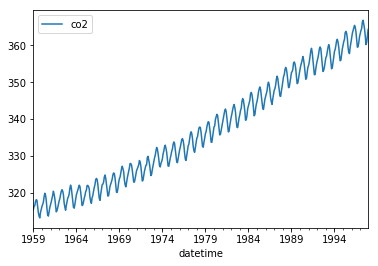

In [15]:
df.plot(x="datetime", y="co2")
plt.show()

In [16]:
df["y"] = df["co2"].diff()
df2 = df.iloc[1:, :]

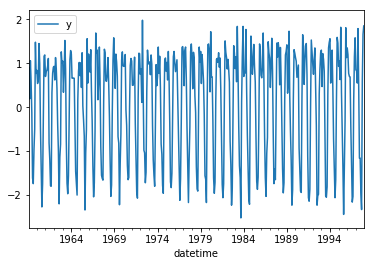

In [17]:
df2.plot(x="datetime", y="y")
plt.show()

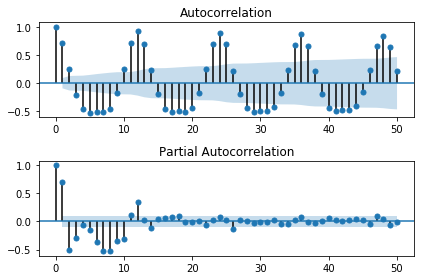

In [18]:
ax1 = plt.subplot(211); sm.graphics.tsa.plot_acf(df2["y"], lags=50, ax=ax1)
ax2 = plt.subplot(212); sm.graphics.tsa.plot_pacf(df2["y"], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

하지만 여기에서 특정한 달, 예를 들어 1월달의 자료만 떼어서 보면 다음과 같다.

In [19]:
df2.loc[:, "month"] = df2.datetime.dt.month.values
df2.tail()

/home/jihoon_kim/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/jihoon_kim/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,time,co2,datetime,y,month
463,1997.583333,362.57,1997-08-01,-1.95,8
464,1997.666667,360.24,1997-09-01,-2.33,9
465,1997.750000,360.83,1997-10-01,0.59,10
466,1997.833333,362.49,1997-11-01,1.66,11
467,1997.916667,364.34,1997-12-01,1.85,12


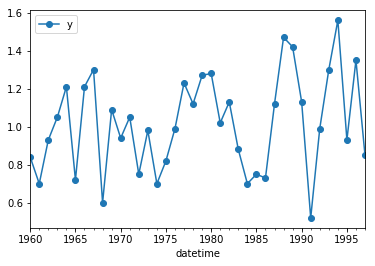

In [20]:
df2[df2.month == 1].plot(x="datetime", y="y", marker='o')
plt.show()

이렇게 분리된 시계열은 다음과 같이 간단히 백색잡음 또는 ARMA로 모형화할 수 있다.

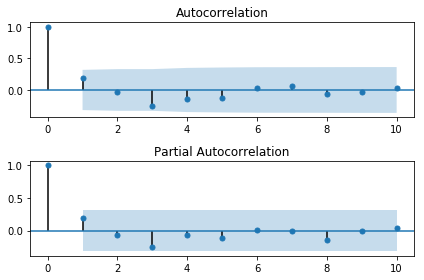

In [21]:
ax1 = plt.subplot(211); sm.graphics.tsa.plot_acf(df2[df2.month == 1]["y"], lags=10, ax=ax1)
ax2 = plt.subplot(212); sm.graphics.tsa.plot_pacf(df2[df2.month == 1]["y"], lags=10, ax=ax2)
plt.tight_layout()
plt.show()

이렇게 **각 계절별 시계열이 백색잡음이 아닌 일반적인 ARIMA 모형을 따르는**  모형을 **Seasonal ARIMA 모형**이라고 한다.

## 단순 Seasonal ARIMA 모형

Seasonal ARIMA 모형은 줄여서 SARIMA라고 하기도 한다. 단순 SARIMA 모형은 각 계절에 따른 독립적인 ARIMA 모형이 합쳐져 있는 모형이다. 기존 ARIMA(p,d,q) 모형에 계절성 주기를 나타내는 차수 s가 추가적으로 필요하기 때문에 SARIMA(P,D,Q,s) 로 표기한다.

s의 값은 월별 계절성을 나타낼 때는 $s=12$가 되고 분기별 계절성을 나타낼 때는 $s=4$가 된다.

### 단순 Seasonal MA 모형

예를 들어 각 월의 시계열 자료 값이 현재의 백색 잡음 이외에 작년 동월의 백색 잡음에도 영향을 받는다면 다음과 같은 단순 SARIMA(0,0,1,12) 모형이 된다. 

$$ Y_t = e_t - \Theta e_{t-12} $$

이 시계열은 시차(lag)가 12인 경우에는 자기상관계수가 0이 아니고 다른 경우에는 모두 0이된다. 즉, 다른 달끼리는 상관관계가 없다. 

$$ \text{Cov}[Y_t, Y_{t-1}] = \text{Cov}[ e_t - \Theta e_{t-12} ,  e_{t-1} - \Theta e_{t-13} ] = 0 $$

$$ \text{Cov}[Y_t, Y_{t-12}] = \text{Cov}[ e_t - \Theta e_{t-12} ,  e_{t-12} - \Theta e_{t-24} ] = -\Theta \sigma_e^2 $$

이 성질은 MA 차수 Q가 1이 아닌 일반적인 경우에도 성립한다. 예를 들어 다음과 같은 일반적인 단순 SARIMA(0,Q,s) 모형의 경우,

$$ Y_t = e_t - \Theta e_{t-12} - \Theta e_{t-2\cdot 12} - \cdots - \Theta e_{t-Q \cdot 12} $$

자기상관계수의 값은 시차가 $ks$인 경우에만 0이 아닌 다음과 같은 값이 되고 다른 시차값에 대해서는 0이 된다.

$$ \rho_{ks} = \dfrac{-\Theta_k + \Theta_{1}\Theta_{k+1} + \Theta_{2}\Theta_{k+2} + \cdots + \Theta_{Q-k}\Theta_{k+Q}}{1 + \Theta_1^2 +\Theta_2^2 + \cdots + \Theta_Q^2} $$

### 단순 Seasonal AR 모형

예를 들어 각 월의 시계열 자료 값이 작년 동월의 자료값 자체에도 영향을 받는다면 다음과 같은 단순 SARIMA(1,0,0,12) 모형이 된다. 

$$ Y_t = \Phi Y_{t-12} + e_t  $$

이 확률 과정은 모수 $\Phi < 1$인 경우에만 정상 과정이 된다.

자기상관계수의 값은 시차가 $ks$인 경우에만 0이 아닌 다음과 같은 값이 되고 다른 시차값에 대해서는 0이 된다.

$$ \rho_{ks} = \Phi^k $$

## 일반적인 단순 Seasonal ARIMA 모형의 표기

ARMA(p,q) 모형은 다음과 같이 수식으로 나타낼 수 있다.

$$ Y_t = \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \cdots + \phi_p Y_{t-p} + e_t - \theta_1 e_{t-1}  - \theta_2 e_{t-2} - \cdots  - \theta_q e_{t-q} $$

$$ Y_t - \phi_1 Y_{t-1} - \phi_2 Y_{t-2} - \cdots - \phi_p Y_{t-p} = e_t - \theta_1 e_{t-1}  - \theta_2 e_{t-2} - \cdots  - \theta_q e_{t-q} $$

이를 시간 지연 연산자 $L$을 사용하면 다음과 같이 표기하기도 한다.

$$ \phi(L)Y_t = \theta(L)e_t $$

여기에서 $\phi(L)$과 $\theta(L)$은 다음과 같은 다항식을 표시한다.

$$ \phi(L) = 1 - \phi_1 L - \phi_2 L^2 - \cdots - \phi_p L^p  $$

$$ \theta(L) = 1 - \theta_1 L - \theta_2 L^2 - \cdots - \theta_q L^q  $$

이 다항식은 원래의 모형 수식을 다음과 같이 간결하게 나타내기 위한 것이다.

$$ 
\begin{eqnarray}
Y_t - \phi_1 Y_{t-1} - \phi_2 Y_{t-2} - \cdots - \phi_p Y_{t-p} 
&=& Y_t - \phi_1 LY_t - \phi_2 L^2Y_t - \cdots - \phi_p L^pY_t \\
&=& (1 - \phi_1 L - \phi_2 L^2 - \cdots - \phi_p L^p)Y_t \\
&=& \phi(L)Y_t \\
\end{eqnarray}
$$

일반적인 단순 Seasonal ARIMA (P,0,Q,S) 모형은 모든 시간 지연이 s의 배수이기 때문에 다음과 같이 표기한다.

$$ \phi(L^s)Y_t = \theta(L^s)e_t $$

이를 풀면 다음과 같은 의미이다.

$$ Y_t = \phi_1 Y_{t-s} + \phi_2 Y_{t-2s} + \cdots + \phi_P Y_{t-Ps} + e_t - \theta_1 e_{t-s}  - \theta_2 e_{t-2s} - \cdots  - \theta_Q e_{t-Qs} $$

ARIMA(p,1,q) 모형은 다음과 같이 수식으로 나타낼 수 있다.

$$ Y_t-Y_{t-1} - \phi_1 (Y_{t-1}-Y_{t-2}) - \phi_2 (Y_{t-2}-Y_{t-3}) - \cdots - \phi_p (Y_{t-p}-Y_{t-p-1}) = e_t - \theta_1 e_{t-1}  - \theta_2 e_{t-2} - \cdots  - \theta_q e_{t-q} $$

$$ \nabla Y_t - \phi_1 \nabla Y_{t-1} - \phi_2 \nabla Y_{t-2} - \cdots - \phi_p \nabla Y_{t-p} = e_t - \theta_1 e_{t-1}  - \theta_2 e_{t-2} - \cdots  - \theta_q e_{t-q} $$

$$ \phi(L)\nabla Y_t = \theta(L)e_t $$

ARIMA(p,d,q) 모형은 다음과 같이 수식으로 나타낼 수 있다.

$$ \phi(L)\nabla^d Y_t = \theta(L)e_t $$

이 식에서 $\nabla^d$는 $d$번 차분하는 연산을 의미한다.

단순 Seasonal ARIMA (P,1,Q,S) 모형은 다음과 같이 쓸 수 있다.

$$ \phi(L^s)\nabla_s Y_t = \theta(L^s)e_t $$

이 식에서 $\nabla_s$는 $s$-시간 지연 차분을 나타낸다. 즉 $\nabla_s Y_t = Y_t - Y_{t-s}$이다. 이 식을 풀면 다음과 같은 의미이다.

$$ Y_t-Y_{t-s} - \phi_1 (Y_{t-s}-Y_{t-2s}) - \phi_2 (Y_{t-2s}-Y_{t-3s}) - \cdots - \phi_P (Y_{t-Ps}-Y_{t-(P-1)s}) = e_t - \theta_1 e_{t-s}  - \theta_2 e_{t-2s} - \cdots  - \theta_Q e_{t-Qs} $$

단순 Seasonal ARIMA (P,D,Q,S) 모형은 다음과 같이 쓸 수 있다.

$$ \phi(L^s)\nabla_s^D Y_t = \theta(L^s)e_t $$

이 식에서 $\nabla_s^d$는 $s$-시간 지연 차분을 $D$번 반복하는 연산을 의미한다.